# Velocity Sim2real Transfer: Learning to Filter Noise
---
> Training velocity GNN(1) model with noisy input features

- All simulated movies, regardless of their simulation param-s, use the same *normalisation constants*.
- Hara movies (node velocity data) and ablation (recoil data) movies have different spatio-temporal resolutions:
    - After scaling them to the same length scale and frame rate (microns/10s), we use the average edge length to normalise spatial variables (displacement and position; frame rate is assumed to be 10s for all movies including the simulated movies)

|Dataset | Details | Shortname| Avg. edge len.| Transforms (Normalisation)|
|:---:|:---|:---|---:|:---|
|Synthetic datasets     | vertex dynamics simulations| "train" and "val"| 1.0 a.u.| `[Pos2Vec(scale=10*1.0)`, `ScaleVelocity(0.5*1.0)`, `ScaleTension(0.634,shift=0.6)`, `ScalePressure(0.33,shift=0.1)]`|
|Hara movies    | no force information       | "hara"| 26.32 pixels|`[Pos2Vec(scale=10*26.32)`,`ScaleVelocity(0.5*26.32)]`|
|Hara ablation | short movies w/ recoil data| "abln"| 26.32*0.4/0.21 pixels | (not used for testing velocity) |


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from os import path
import datetime

from torch_geometric.data import Data, DataLoader
import torch_geometric.transforms as T

from torch_geometric.utils import to_networkx, from_networkx
import networkx as nx
from simgnn.datautils import load_array, load_graph

import matplotlib.pyplot as plt
import matplotlib
plt.style.use(['seaborn-paper', 'seaborn-ticks'])
# import seaborn as sns
# sns.set_theme(context='paper', style='ticks')

%matplotlib inline
# matplotlib.rcParams['figure.figsize'] = (10,10) # use larger for presentation
# matplotlib.rcParams['font.size']= 16 # use 14 for presentation

In [3]:
from simgnn.datasets import persistence_loss, VertexDynamics, HaraMovies
from simgnn.train import train_model, write_log, load_log, predict, predict_batch
from simgnn.train import plot_velocity_predictions, plot_losses
from simgnn.transforms import Pos2Vec, ScaleVelocity, Reshape_x, AddPosNoise #, ScaleTension, ScalePressure,
# from torch_geometric.utils import to_undirected as T_undir

In [4]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
dtype = torch.float32
print(f'Defaults:\n |-- device: {device}\n |-- dtype : {dtype}')

Defaults:
 |-- device: cuda
 |-- dtype : torch.float32


---

# GNN(1) Training w/ Noisy Simul-n Data

## Datasets

`CellData` prop-s (graph data objects):
- `x` : `(#nodes, WindowWidth, 2)` *node features*
- `y` : `(#nodes, 2)` *node targets (velocities)*.
- `pos` : `(#nodes, 2)` *node positions*.
- `edge_attr` : `(#edges, 2)` or `(#edges, #edge_features)` *edge features  (relative Cartesian positions of connected nodes)*.
- `edge_index` : `(2, #edges)` *edge indices*.
- `edge_tensions` : `(#edges,)` *edge targets (line tensions)*.
- `node2cell_index` : `(2, #cell2node_edges)`, `node2cell`-> *first row is node indices and second row is cell indices;
- `cell2node_index` : `(2, #cell2node_edges)`, `cell2node`-> *first row is cell indices and second row is node indices*.
- `cell_pressures` : `(#cells,)` *cell targets (cell pressures)*.

In [10]:
def clear_processed_datasets():
    !rm -dr simgnn_data/single_distr_sims/train/processed
    !rm -dr simgnn_data/single_distr_sims/val/processed

    !rm -dr simgnn_data/unimodal_wbasetens_sims/train/processed
    !rm -dr simgnn_data/unimodal_wbasetens_sims/val/processed

    !rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg001/processed/
    !rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg003/processed/
    !rm -dr simgnn_data/hara_movies_as_sep_datasets/hara_seg005/processed/
    
    !rm -dr simgnn_data/hara_movies_as_sep_datasets_copy/hara_seg001/processed/
    !rm -dr simgnn_data/hara_movies_as_sep_datasets_copy/hara_seg003/processed/
    !rm -dr simgnn_data/hara_movies_as_sep_datasets_copy/hara_seg005/processed/

In [11]:
# clear_processed_datasets()

- Average lengths

In [12]:
window_size = 5
n_hidden_layers = 10

sma_lag_time = 4

# average edge lengths
l_0 = {'sim':1.0, 'single_distr_sims':1.1, 'unimodal_wbasetens_sims':0.91, 'hara':26.32, 'abln':50.13}

In [13]:
# Noise for training data
pos_noise = torch.normal
noise_args= [0, 0.03] #[0,1]
frac  = 1 # 100%*frac of nodes
coeffs = {'x': np.sqrt(2)*l_0['sim'], 'pos':1.0*l_0['sim']}
# coeffs = l_0['sim']
coeff_name = 'cxSqrt2' if isinstance(coeffs, dict) else ''

In [154]:
# Normalisation: for simulated data (simul params ~ normal distr-s): l0=1.0, Hara_movie: l0=26.32
# Tnorm = T.Compose([Pos2Vec(scale=1.0*10.0) , ScaleVelocity(1.0*0.5), Reshape_x((-1,window_size*2)) ] )
# Hara movie normalisation
# Tnorm_hara = T.Compose([Pos2Vec(scale=10*26.32) , ScaleVelocity(0.5*26.32), Reshape_x((-1,window_size*2))])

# Use mean edge len w/o additional scaling for vel-y and edge len-s
Tnorms = {}

Tnorms['hara'] = T.Compose([ Pos2Vec(scale=l_0['hara']), ScaleVelocity(l_0['hara']), Reshape_x((-1,window_size*2))])

Tnorms['sim'] = T.Compose([ AddPosNoise(pos_noise, frac=frac, coeffs=coeffs, noise_args=noise_args),
                         Pos2Vec(scale=l_0['sim']) , ScaleVelocity(l_0['sim']), Reshape_x((-1,window_size*2)) ] )

Tnorms['sim_val'] = T.Compose([ Pos2Vec(scale=l_0['sim']) , ScaleVelocity(l_0['sim']), Reshape_x((-1,window_size*2)) ] )

velocity_scale = {'train':l_0['sim'], 'val':l_0['sim'], 'val2':l_0['sim'], 'hara':l_0['hara']}

In [155]:
clear_processed_datasets()

# Hara movie datasets (denoised)
seg001 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg001/', window_size=window_size,
                    transform=Tnorms['hara'], smoothing=True, sma_lag_time=sma_lag_time)
# seg003 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg003/', window_size=window_size,
#                     transform=Tnorms['hara'],smoothing=True, sma_lag_time=sma_lag_time)
# seg005 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg005/', window_size=window_size,
#                     transform=Tnorms['hara'],smoothing=True, sma_lag_time=sma_lag_time)

seg001_raw = HaraMovies('simgnn_data/hara_movies_as_sep_datasets_copy/hara_seg001/', window_size=window_size,
                    transform=Tnorms['hara'], smoothing=False)

# Simulation datasets
sim1 = VertexDynamics('./simgnn_data/unimodal_wbasetens_sims/train/', window_size=window_size, transform=Tnorms['sim'])
sim1_val = VertexDynamics('./simgnn_data/unimodal_wbasetens_sims/val/', window_size=window_size, transform=Tnorms['sim_val'])
# sim2 = VertexDynamics('./simgnn_data/single_distr_sims/train/', window_size=window_size, transform=Tnorms['sim'])
sim2_val = VertexDynamics('./simgnn_data/single_distr_sims/val/', window_size=window_size, transform=Tnorms['sim_val'])

datasets_dict = {'train': sim1,
                 'val': sim1_val,
                 'val2' : sim2_val,
                 'H1' : seg001,
                 'H1raw' : seg001_raw,
#                  'hara' : hara,
                }
dataset_legend={'train': 'Train($\mathcal{H}_1$)',
                'val': 'Supervised($\mathcal{D}_{sim1}$)',
                'val2': 'Sim2sim($\mathcal{D}_{sim2}$)',
                'H1': 'Sim2real($\mathcal{H}_1$)',
                'H1raw': 'Sim2real($\mathcal{H}_1$); raw'
                }

rm: cannot remove 'simgnn_data/single_distr_sims/train/processed': No such file or directory
rm: cannot remove 'simgnn_data/hara_movies_as_sep_datasets/hara_seg003/processed/': No such file or directory
rm: cannot remove 'simgnn_data/hara_movies_as_sep_datasets/hara_seg005/processed/': No such file or directory
rm: cannot remove 'simgnn_data/hara_movies_as_sep_datasets_copy/hara_seg003/processed/': No such file or directory
rm: cannot remove 'simgnn_data/hara_movies_as_sep_datasets_copy/hara_seg005/processed/': No such file or directory
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!
Processing...
Done!


In [156]:
# datasets_dict[k][0].pos.numpy() - datasets_dict[k][0].pos.numpy()

In [157]:
# datasets_dict['train'].processed_file_names

In [158]:
# k='train'
# print('{} : {}\nsize:{}\n\nFrame 1:\n{}'.format(k,datasets_dict[k],len(datasets_dict[k]),datasets_dict[k][0]))
# plt.figure(figsize=[2.5,2.5])
# nx.draw(to_networkx(datasets_dict[k][0]),pos=dict(enumerate(datasets_dict[k][0].pos.numpy())), node_size=10)

## Single Message Passing Step
> Single MP step, uses graph and relative node positions w.r.t. connected neighbouring nodes

- Single MP step w/ a very simple Update mlp. Update stage is equivalent to the node model (plain mlp) w/ an additional edge features as messages.

In [16]:
from simgnn.models import Single_MP_step

In [164]:
dropout_p = 0.1
num_epochs = 1000
lr = 0.001

bs = 2

loaders = {'train' : DataLoader(datasets_dict['train'], batch_size=bs, shuffle=True),
           'val': DataLoader(datasets_dict['val'], batch_size=bs),
#            'val2': DataLoader(datasets_dict['val2'], batch_size=bs),
#           'hara': DataLoader(datasets_dict['hara'], batch_size=bs)
          }

model_states = list(loaders.keys())
use_force_loss = {k:[False,False] for k in loaders}

loss_func = torch.nn.MSELoss(reduction='mean')

GNN_save_dir = './simgnn_data/saved_models/thesis/2C_dp_sim2real_learning_noise/'

### GNN(1) aka single graph layer (message and update) sizes
> The output layer of the message MLP in a 1-layer GNN model counted as a hidden layer

In [ ]:
torch.manual_seed(42)

msg_dim = 32  # message MLP latent dim-s
upd_dim = 128  # update MLP latent dim-s

upd_h_layers = max([0, n_hidden_layers//2])# Update MLP hidden_layers
update_hidden_dims=[upd_dim for k in range(upd_h_layers-1)]+[16]

msg_h_layers = max([0, n_hidden_layers - upd_h_layers])# Message MLP hidden_layers
message_hidden_dims = [msg_dim for k in range(msg_h_layers-1)] # assume output layer is hidden for MP step model


print(f'{k}: N(h_dims)={n_hidden_layers}')

net = Single_MP_step(node_in_features=window_size*2, node_out_features=2, edge_in_features=2,
                     message_out_features=msg_dim, message_hidden_dims=message_hidden_dims,
                     aggr='mean', update_hidden_dims=update_hidden_dims,
                     dropout_p=dropout_p).to(device)

opt = torch.optim.Adam(net.parameters(), lr=lr)
scheduler = None

return_best = False
model_name = f'{net.__class__.__name__}_sd{noise_args[1]}f{frac}{coeff_name}_epochs{num_epochs}'

print(model_name,end='\n---\n')
net, train_log = train_model(net, loaders, opt, num_epochs=num_epochs, scheduler=None, device=device,
                             model_states = model_states, loss_func = loss_func,
                             use_force_loss=use_force_loss, return_best=return_best)

# plot losses
plot_losses(train_log, loaders, dataset_legend, figsize=[7,4]); plt.show()


# MODEL SAVING:

write_log(f'{path.join(GNN_save_dir, model_name)}_log.pkl',train_log)
model_save_path = path.join(GNN_save_dir, model_name+'.pkl')
torch.save(net.state_dict(), model_save_path)
print(f'Model weights saved in \n{model_save_path}\n---\n')

In [ ]:
pred_loaders = {
#     'train' : DataLoader(datasets_dict['train'], batch_size=bs, shuffle=True),
                'val': DataLoader(datasets_dict['val'], batch_size=bs),
                'val2': DataLoader(datasets_dict['val2'], batch_size=bs),
                'H1': DataLoader(datasets_dict['H1'], batch_size=bs),
                'H1raw': DataLoader(datasets_dict['H1raw'], batch_size=bs),
               }
# compute predictions and plot them
pred_out, tgt_out, sample_losses = predict_batch(net, pred_loaders,
                                                 loss_func=torch.nn.MSELoss(reduction='sum'),
                                                 use_force_loss = {k: False for k in pred_loaders},
                                                 return_losses = True, device=device)
print(''.join([f'- {k} ={sample_losses[k]};\n' for k in sample_losses]))

plot_velocity_predictions(pred_out[0], tgt_out[0], dataset_legend, subplots_kw={'figsize':[8,3.5]})

```
coeff = {'x': np.sqrt(2)*l_0['sim'], 'pos':1.0*l_0['sim']}
f=0.3; sd=0.01
- val_loss_y =0.00014772496279573182;
- val2_loss_y =0.0002205065226801124;
- H1_loss_y =0.00010273008609392955;
- H1raw_loss_y =0.0018718269209639724;
f=1.0; sd=0.03 # HIGH BIAS--> Noise injection acts as a regularisation constraint!
- val_loss_y =0.0005726190656179448;
- val2_loss_y =0.0006900143062511644;
- H1_loss_y =0.00016935544290854504;
- H1raw_loss_y =0.0011007516915412278;
```

---
```
f=0.2; sd=0.001;
- val_loss_y =0.00011222623120798079;
- val2_loss_y =0.00017364779707683615;
- H1_loss_y =0.00021233829832790696;
- H1raw_loss_y =0.005644451527796405;

sd=0.01
- val_loss_y =0.0001295140943200685;
- val2_loss_y =0.00019427845789873793;
- H1_loss_y =0.00010998991613344449;
- H1raw_loss_y =0.0028997599814260615;
sd=0.03
- val_loss_y =0.0001380167705303505;
- val2_loss_y =0.00021085752404923926;
- H1_loss_y =0.00011749314949610282;
- H1raw_loss_y =0.0013095034364850452;
sd=0.1
- val_loss_y =0.00014190938946855686;
- val2_loss_y =0.0002178387277124297;
- H1_loss_y =0.00016547521852997612;
- H1raw_loss_y =0.0018628526057742388;
sd=0.3
- val_loss_y =0.00013540205493847672;
- val2_loss_y =0.00021272544872680157;
- H1_loss_y =0.00018553323548146732;
- H1raw_loss_y =0.003279668165416252;
```

---
```
f=0.05; sd=0.01
- val_loss_y =0.000117523342948944;
- val2_loss_y =0.0001772897342016837;
- H1_loss_y =0.00015277827154440256;
- H1raw_loss_y =0.003758851361116126;
f=0.1
- val_loss_y =0.00012324319625710325;
- val2_loss_y =0.00018600442813629077;
- H1_loss_y =0.00013637467413446855;
- H1raw_loss_y =0.0032307971475393966;
f=0.3
- val_loss_y =0.00014252006564518805;
- val2_loss_y =0.00021017055733354536;
- H1_loss_y =9.706326886317683e-05;
- H1raw_loss_y =0.0027630896367413504;
f=0.5
- val_loss_y =0.00015945568910237222;
- val2_loss_y =0.00023085957185214895;
- H1_loss_y =8.360448844747375e-05;
- H1raw_loss_y =0.002515228730347627;
f=1.0
- val_loss_y =0.00019442476622081638;
- val2_loss_y =0.00027197577328510135;
- H1_loss_y =8.42321765280748e-05;
- H1raw_loss_y =0.002145789206820951;
```

## Longer training test for corrupting a smaller portion

```
Corrupting 30 % of nodes
========================
f=0.3; sd=0.03
Single_MP_step_sd0.03f0.3cxSqrt2_epochs1000.pkl
---
- val_loss_y =0.00014857835332261274;
- val2_loss_y =0.00022444450288589034;
- H1_loss_y =0.00014537067798910014;
- H1raw_loss_y =0.0011164773693370185;

f=0.5; sd=0.03
Single_MP_step_sd0.03f0.5cxSqrt2_epochs1000.pkl
---
- val_loss_y =0.00015593221857240557;
- val2_loss_y =0.00023825398830512723;
- H1_loss_y =0.00014722830411501047;
- H1raw_loss_y =0.0011049167379043054;

f=1.0; sd=0.03
Single_MP_step_sd0.03f1.0cxSqrt2_epochs1000.pkl
---
- val_loss_y =0.0006464833307029925;
- val2_loss_y =0.0007694661404720224;
- H1_loss_y =0.00017218155303181144;
- H1raw_loss_y =0.001068703876498533;
```

In [20]:
from simgnn.models import Single_MP_step

In [22]:
# Noise for training data
pos_noise = torch.normal
noise_args= [0, 0.01] #[0,1]
fracs  = [0.3, 0.5, 1.0] # 100%*frac of nodes
coeffs = {'x': np.sqrt(2)*l_0['sim'], 'pos':1.0*l_0['sim']}
coeff_name = 'cxSqrt2' if isinstance(coeffs, dict) else ''

velocity_scale = {'train':l_0['sim'], 'val':l_0['sim'], 'val2':l_0['sim'], 'hara':l_0['hara']}


In [ ]:
for k, frac in enumerate(fracs):
    # clear_processed_datasets()
    # Use mean edge len w/o additional scaling for vel-y and edge len-s
    Tnorms = {}

    Tnorms['hara'] = T.Compose([ Pos2Vec(scale=l_0['hara']), ScaleVelocity(l_0['hara']), Reshape_x((-1,window_size*2))])

    Tnorms['sim'] = T.Compose([ AddPosNoise(pos_noise, frac=frac, coeffs=coeffs, noise_args=noise_args),
                             Pos2Vec(scale=l_0['sim']) , ScaleVelocity(l_0['sim']), Reshape_x((-1,window_size*2)) ] )

    Tnorms['sim_val'] = T.Compose([ Pos2Vec(scale=l_0['sim']) , ScaleVelocity(l_0['sim']), Reshape_x((-1,window_size*2)) ] )

    # Hara movie datasets (denoised)
    seg001 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg001/', window_size=window_size,
                        transform=Tnorms['hara'], smoothing=True, sma_lag_time=sma_lag_time)
    # seg003 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg003/', window_size=window_size,
    #                     transform=Tnorms['hara'],smoothing=True, sma_lag_time=sma_lag_time)
    # seg005 = HaraMovies('simgnn_data/hara_movies_as_sep_datasets/hara_seg005/', window_size=window_size,
    #                     transform=Tnorms['hara'],smoothing=True, sma_lag_time=sma_lag_time)

    seg001_raw = HaraMovies('simgnn_data/hara_movies_as_sep_datasets_copy/hara_seg001/', window_size=window_size,
                        transform=Tnorms['hara'], smoothing=False)

    # Simulation datasets
    sim1 = VertexDynamics('./simgnn_data/unimodal_wbasetens_sims/train/', window_size=window_size, transform=Tnorms['sim'])
    sim1_val = VertexDynamics('./simgnn_data/unimodal_wbasetens_sims/val/', window_size=window_size, transform=Tnorms['sim_val'])
    # sim2 = VertexDynamics('./simgnn_data/single_distr_sims/train/', window_size=window_size, transform=Tnorms['sim'])
    sim2_val = VertexDynamics('./simgnn_data/single_distr_sims/val/', window_size=window_size, transform=Tnorms['sim_val'])

    datasets_dict = {'train': sim1,
                     'val': sim1_val,
                     'val2' : sim2_val,
                     'H1' : seg001,
                     'H1raw' : seg001_raw,
    #                  'hara' : hara,
                    }
    dataset_legend={'train': 'Train($\mathcal{H}_1$)',
                    'val': 'Supervised($\mathcal{D}_{sim1}$)',
                    'val2': 'Sim2sim($\mathcal{D}_{sim2}$)',
                    'H1': 'Sim2real($\mathcal{H}_1$)',
                    'H1raw': 'Sim2real($\mathcal{H}_1$); raw'
                    }
    
    torch.manual_seed(420+k)

    dropout_p = 0.1
    num_epochs = 1000
    lr = 0.001
    bs = 2
    
    loaders = {'train' : DataLoader(datasets_dict['train'], batch_size=bs, shuffle=True),
               'val': DataLoader(datasets_dict['val'], batch_size=bs)}

    model_states = list(loaders.keys())
    use_force_loss = {k:[False,False] for k in loaders}

    loss_func = torch.nn.MSELoss(reduction='mean')

    GNN_save_dir = './simgnn_data/saved_models/thesis/2C_dp_sim2real_learning_noise/sd0.01_1000epochs/'

    # # # #

    msg_dim = 32  # message MLP latent dim-s
    upd_dim = 128  # update MLP latent dim-s

    upd_h_layers = max([0, n_hidden_layers//2])# Update MLP hidden_layers
    update_hidden_dims=[upd_dim for k in range(upd_h_layers-1)]+[16]

    msg_h_layers = max([0, n_hidden_layers - upd_h_layers])# Message MLP hidden_layers
    message_hidden_dims = [msg_dim for k in range(msg_h_layers-1)] # assume output layer is hidden for MP step model


    print(f'{k}: N(h_dims)={n_hidden_layers}')

    net = Single_MP_step(node_in_features=window_size*2, node_out_features=2, edge_in_features=2,
                         message_out_features=msg_dim, message_hidden_dims=message_hidden_dims,
                         aggr='mean', update_hidden_dims=update_hidden_dims,
                         dropout_p=dropout_p).to(device)

    opt = torch.optim.Adam(net.parameters(), lr=lr)
    scheduler = None

    return_best = False
    model_name = f'{net.__class__.__name__}_sd{noise_args[1]}f{frac}{coeff_name}_epochs{num_epochs}'

    print(model_name,end='\n---\n')
    net, train_log = train_model(net, loaders, opt, num_epochs=num_epochs, scheduler=None, device=device,
                                 model_states = model_states, loss_func = loss_func,
                                 use_force_loss=use_force_loss, return_best=return_best)

    # plot losses
    plot_losses(train_log, loaders, dataset_legend, figsize=[7,4]); plt.show()


    # MODEL SAVING:

    write_log(f'{path.join(GNN_save_dir, model_name)}_log.pkl',train_log)
    model_save_path = path.join(GNN_save_dir, model_name+'.pkl')
    torch.save(net.state_dict(), model_save_path)
    print(f'Model weights saved in \n{model_save_path}\n---\n')
    
    pred_loaders = {
    #     'train' : DataLoader(datasets_dict['train'], batch_size=bs, shuffle=True),
                    'val': DataLoader(datasets_dict['val'], batch_size=bs),
                    'val2': DataLoader(datasets_dict['val2'], batch_size=bs),
                    'H1': DataLoader(datasets_dict['H1'], batch_size=bs),
                    'H1raw': DataLoader(datasets_dict['H1raw'], batch_size=bs),
                   }
    # compute predictions and plot them
    pred_out, tgt_out, sample_losses = predict_batch(net, pred_loaders,
                                                     loss_func=torch.nn.MSELoss(reduction='sum'),
                                                     use_force_loss = {k: False for k in pred_loaders},
                                                     return_losses = True, device=device)
    print(''.join([f'- {k} ={sample_losses[k]};\n' for k in sample_losses]))

    plot_velocity_predictions(pred_out[0], tgt_out[0], dataset_legend, subplots_kw={'figsize':[8,3.5]})

0: N(h_dims)=10
Single_MP_step_sd0.01f0.3cxSqrt2_epochs1000
---
Training param-s: #epochs=1000, metric=MSELoss(), batch_size=2, optim=Adam, sch-r=none, return_best=False
---
Epoch 0/999: train_loss_tot=0.004826; train_loss_y=0.004826; |val_loss_tot=0.001293; |3s
Epoch 1/999: train_loss_tot=0.001765; train_loss_y=0.001765; |val_loss_tot=0.0005297; |7s
Epoch 2/999: train_loss_tot=0.001079; train_loss_y=0.001079; |val_loss_tot=0.0003696; |10s
Epoch 3/999: train_loss_tot=0.0008959; train_loss_y=0.0008959; |val_loss_tot=0.0003856; |13s
Epoch 4/999: train_loss_tot=0.0007884; train_loss_y=0.0007884; |val_loss_tot=0.0003293; |16s
Epoch 5/999: train_loss_tot=0.0007072; train_loss_y=0.0007072; |val_loss_tot=0.000291; |19s
Epoch 6/999: train_loss_tot=0.0006495; train_loss_y=0.0006495; |val_loss_tot=0.000295; |22s
Epoch 7/999: train_loss_tot=0.0006096; train_loss_y=0.0006096; |val_loss_tot=0.0002863; |26s
Epoch 8/999: train_loss_tot=0.0005754; train_loss_y=0.0005754; |val_loss_tot=0.0002786; |29s


---

## Load Model and Check Performance

In [13]:
bs = 2
pred_loaders = {'train' : DataLoader(datasets_dict['train'], batch_size=bs, shuffle=True),
           'val': DataLoader(datasets_dict['val'], batch_size=bs),
           'val2': DataLoader(datasets_dict['val2'], batch_size=bs),
          'hara': DataLoader(datasets_dict['hara'], batch_size=bs)
          }

### Simple GNN (1-MP layer)

In [100]:
from simgnn.models import Single_MP_step

In [101]:
save_dir = './simgnn_data/saved_models/thesis/velocity_MP_real2real/'

num_layers = 10

dropout_p = 0.1

upd_h_layers = max([0, num_layers//2])# Update MLP hidden_layers
update_hidden_dims=[128 for k in range(upd_h_layers-1)]+[16]
msg_h_layers = max([0, num_layers - upd_h_layers])# Message MLP hidden_layers
message_hidden_dims = [32 for k in range(msg_h_layers-1)] # assume output layer is hidden for MP step model

model_name = f'Single_MP_step_h{num_layers}_dp{dropout_p}bs2w5.pkl'
print(f'Loading:\n\t{model_name}')

net = Single_MP_step(node_in_features=window_size*2, node_out_features=2, edge_in_features=2,
                     message_out_features=32, message_hidden_dims=message_hidden_dims,
                     aggr='mean', update_hidden_dims=update_hidden_dims, dropout_p=dropout_p).to(device)
net_weights_dict = torch.load(path.join(save_dir, model_name), map_location=device)
net.load_state_dict(net_weights_dict)
net.eval();

# compute predictions and plot them
pred_out, tgt_out, sample_losses = predict_batch(net, pred_loaders,
                                                 loss_func=torch.nn.MSELoss(reduction='sum'),
                                                 use_force_loss = {k: False for k in pred_loaders},
                                                 return_losses = True, device=device)
print(''.join([f'- {k} ={sample_losses[k]};\n' for k in sample_losses]))

Loading:
	Single_MP_step_h10_dp0.1bs2w5.pkl
- train_loss_tot =0.00017289492619655482;
- train_loss_y =0.00017289492619655482;
- train_loss_T =0.0;
- train_loss_P =0.0;
- val_loss_tot =0.00021682040902172646;
- val_loss_y =0.00021682040902172646;
- val_loss_T =0.0;
- val_loss_P =0.0;
- mid_loss_tot =0.00010372566669678488;
- mid_loss_y =0.00010372566669678488;
- mid_loss_T =0.0;
- mid_loss_P =0.0;
- late_loss_tot =0.00010987656334271798;
- late_loss_y =0.00010987656334271798;
- late_loss_T =0.0;
- late_loss_P =0.0;



---

## Movie Predictions

In [102]:
!rm -dr simgnn_data/hara_movies/processed

In [103]:
hara = HaraMovies('simgnn_data/hara_movies/', window_size=window_size, transform=Tnorms['hara'], smoothing=True, sma_lag_time=4)

Processing...
Done!


In [133]:
dataset_mov_names = {}
dataset_mov_idx = {}
dataset_mov = {}

d_names_list = [k.split('_')[2] for k in hara.processed_file_names]
    
dataset_mov_names['hara'] = {k : ki for ki, k in enumerate(np.unique(d_names_list))}
    
dataset_mov_idx['hara'] = torch.tensor([dataset_mov_names['hara'][k] for k in d_names_list])
    
dataset_mov['hara'] = {k:hara[dataset_mov_names['hara'][k]==dataset_mov_idx['hara']]
                              for k in dataset_mov_names['hara']}
dataset_mov

{'hara': {'001': HaraMovies(55), '003': HaraMovies(55), '005': HaraMovies(55)}}

- **Model Predictions for Movies**; Predict `Velocity[T+1]` for movies

In [134]:
from simgnn.train import np_loss_wrt_time, predict_dataset

from scipy.stats import pearsonr

In [135]:
velocity_scale

{'train': 1.0, 'val': 1.0, 'val2': 1.0, 'hara': 26.32}

In [136]:
ignore_short_edges, edge_len_threshold = False, 10**-4

In [137]:
model_results = {}
loss_type = 'mse'

for dataset_k in dataset_mov:
    print('-'*10+'\n'+dataset_k)
    model_results[dataset_k] = {}
    for mov_i in dataset_mov[dataset_k]:
        if None != dataset_mov[dataset_k][mov_i][0].edge_id:
            num_edges = torch.unique(dataset_mov[dataset_k][mov_i][0].edge_id).size(0)
        else:
            num_edges = dataset_mov[dataset_k][mov_i][0].num_edges
        print('\t',mov_i,f': len={len(dataset_mov[dataset_k][mov_i])};',
              f'E_n={num_edges};',
              f'V_n={dataset_mov[dataset_k][mov_i][0].num_nodes};',
              f'C_n={dataset_mov[dataset_k][mov_i][0].num_cells};', end=' ')

        model_results[dataset_k][mov_i] = predict_dataset(net, dataset_mov[dataset_k][mov_i],device=device, concat=True)


        # Edge indices
        if None != dataset_mov[dataset_k][mov_i][0].edge_id:
            edge_index = dataset_mov[dataset_k][mov_i][0].edge_index[:,torch.unique(dataset_mov[dataset_k][mov_i][0].edge_id)]
        else:
            edge_index = dataset_mov[dataset_k][mov_i][0].edge_index

        model_results[dataset_k][mov_i]['edge_index'] = edge_index
        
        # Vertex pos [targets]
        pos = np.concatenate([d.pos.reshape(1,-1,2) for d in dataset_mov[dataset_k][mov_i]],axis=0)
        model_results[dataset_k][mov_i]['targets']['pos'] = pos
        
        # Edge lengths [targets]
        edge_lengths = np.linalg.norm(pos[:, edge_index[1],:] - pos[:, edge_index[0],:], axis=-1)
        model_results[dataset_k][mov_i]['targets']['edge_lengths'] = edge_lengths
        
        # Compute predicted vertex pos, edge lengths
        dx_unnorm = velocity_scale[dataset_k]*model_results[dataset_k][mov_i]['predictions']['velocity']
        # pos predictions w/ velocity (except for first pos)
        pos_preds = np.concatenate([pos[:1],(pos+dx_unnorm)[:-1]], axis=0)
        model_results[dataset_k][mov_i]['predictions']['pos'] = pos_preds

        model_results[dataset_k][mov_i]['predictions']['edge_lengths'] = np.linalg.norm(pos_preds[:, edge_index[1],:] - pos_preds[:, edge_index[0],:], axis=-1)
        if ignore_short_edges:
            edge_mask = np.all(np.concatenate([dk.edge_length.numpy().reshape(1,-1)
                                               for dk in dataset_mov[dataset_k][mov_i]], axis=0) > edge_len_threshold, axis=0)
            model_results[dataset_k][mov_i]['predictions']['edge_masks'] = edge_mask
        else:
            model_results[dataset_k][mov_i]['predictions']['edge_masks'] = None
        
        model_results[dataset_k][mov_i]['loss'] = {}
        
        # velocity losses
        if len(model_results[dataset_k][mov_i]['targets']['velocity']) > 0:
            model_results[dataset_k][mov_i]['loss']['velocity'] = np_loss_wrt_time(model_results[dataset_k][mov_i]['predictions']['velocity'],
                                                                                   model_results[dataset_k][mov_i]['targets']['velocity'])
        else:
            model_results[dataset_k][mov_i]['loss']['velocity'] = np.full((model_results[dataset_k][mov_i]['predictions']['velocity'].shape[1],), np.nan)
        
#         # tension losses
#         if len(model_results[dataset_k][mov_i]['targets']['tension']) > 0:
#             model_results[dataset_k][mov_i]['loss']['tension'] = np_loss_wrt_time(model_results[dataset_k][mov_i]['predictions']['tension'],
#                                                                                   model_results[dataset_k][mov_i]['targets']['tension'])
#         else:
#             model_results[dataset_k][mov_i]['loss']['tension'] = np.full((model_results[dataset_k][mov_i]['predictions']['tension'].shape[1],), np.nan)

#         if ignore_short_edges:
#             model_results[dataset_k][mov_i]['loss']['tension_mask'] = model_results[dataset_k][mov_i]['loss']['tension'].copy()
#             model_results[dataset_k][mov_i]['loss']['tension_mask'][~edge_mask] = np.nan
#         else:
#             model_results[dataset_k][mov_i]['loss']['tension_mask'] = None
        model_results[dataset_k][mov_i]['loss']['edge_lengths'] = np_loss_wrt_time(model_results[dataset_k][mov_i]['predictions']['edge_lengths'],
                                                                                   model_results[dataset_k][mov_i]['targets']['edge_lengths'])
        
        print(f"Losses: Vel-y={np.nanmean(model_results[dataset_k][mov_i]['loss']['velocity']):6.4f}; "+
              f"E_len={np.nanmean(model_results[dataset_k][mov_i]['loss']['edge_lengths']):6.4f}; "+
#               f"Tension={np.nanmean(model_results[dataset_k][mov_i]['loss']['tension']):6.4f};"+
             f"Tension(mask)={np.nanmean(model_results[dataset_k][mov_i]['loss']['tension_mask']) if ignore_short_edges else 0.0:6.4f}")

----------
hara
	 001 : len=55; E_n=225; V_n=164; C_n=128; Losses: Vel-y=0.0001; E_len=0.0862; Tension(mask)=0.0000
	 003 : len=55; E_n=149; V_n=119; C_n=124; Losses: Vel-y=0.0001; E_len=0.0657; Tension(mask)=0.0000
	 005 : len=55; E_n=164; V_n=130; C_n=114; Losses: Vel-y=0.0001; E_len=0.0986; Tension(mask)=0.0000


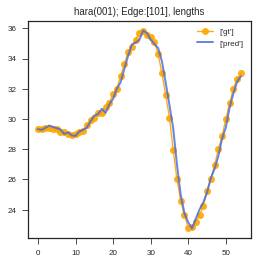

In [138]:
dataset_k, mov_i = 'hara', '001'  # ['val2']['sim005']

# Lij = model_results['targets']['edge_lengths']
# Lij_p = model_results['val2']['sim005']['predictions']['edge_lengths']
Lij = model_results[dataset_k][mov_i]['targets']['edge_lengths']
Lij_p = model_results[dataset_k][mov_i]['predictions']['edge_lengths']

k=[101]
plt.figure(figsize=[4,4])
plt.plot(Lij[:,k], 'o-', c='orange', ms=7, alpha=.9,label=['gt']+[None for ki in k[1:]])
plt.plot(Lij_p[:,k], '-',c='royalblue', lw=2, alpha=.8, label=['pred']+[None for ki in k[1:]]);
plt.title(f'{dataset_k}({mov_i}); Edge:{k}, lengths')
plt.legend();

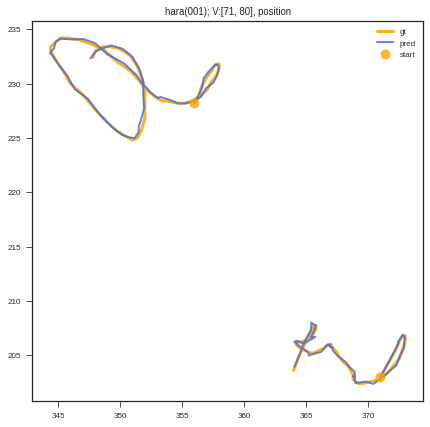

In [139]:
pos = model_results[dataset_k][mov_i]['targets']['pos']
pos_p = model_results[dataset_k][mov_i]['predictions']['pos']

e_st = model_results[dataset_k][mov_i]['edge_index'][:,k]
e_st_list = e_st.ravel().tolist()
plt.figure(figsize=[7,7])
plt.plot(pos[:,e_st_list,0],pos[:,e_st_list,1], '-', c='orange', lw=3, alpha=.9,label=['gt']+[None for k in range(len(e_st_list)-1)])
plt.plot(pos_p[:,e_st_list,0],pos_p[:,e_st_list,1], '-',c='royalblue', lw=2, alpha=.8, label=['pred']+[None for k in range(len(e_st_list)-1)]);

plt.plot(pos[0,e_st_list,0],pos[0,e_st_list,1], 'o', c='orange', ms=10, alpha=.8,label='start')
# for e_k in range(e_st.shape[1]):
#     plt.plot(pos[-1,e_st[:,e_k],0],pos[-1,e_st[:,e_k],1], '-', c='orange', lw=4, alpha=.5)
#     plt.plot(pos_p[-1,e_st[:,e_k],0],pos_p[-1,e_st[:,e_k],1], '-',c='navy', lw=4, alpha=.4);
plt.title(f'{dataset_k}({mov_i}); V:{e_st_list}, position')
# plt.xlim([340, 380])
# plt.ylim([240, 200])
# plt.axis(False)
plt.legend();

**Noise training noisy eval**

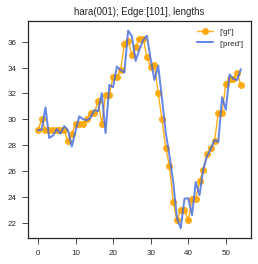

In [90]:
dataset_k, mov_i = 'hara', '001'  # ['val2']['sim005']

# Lij = model_results['targets']['edge_lengths']
# Lij_p = model_results['val2']['sim005']['predictions']['edge_lengths']
Lij = model_results[dataset_k][mov_i]['targets']['edge_lengths']
Lij_p = model_results[dataset_k][mov_i]['predictions']['edge_lengths']

k=[101]
plt.figure(figsize=[4,4])
plt.plot(Lij[:,k], 'o-', c='orange', ms=7, alpha=.9,label=['gt']+[None for ki in k[1:]])
plt.plot(Lij_p[:,k], '-',c='royalblue', lw=2, alpha=.8, label=['pred']+[None for ki in k[1:]]);
plt.title(f'{dataset_k}({mov_i}); Edge:{k}, lengths')
plt.legend();

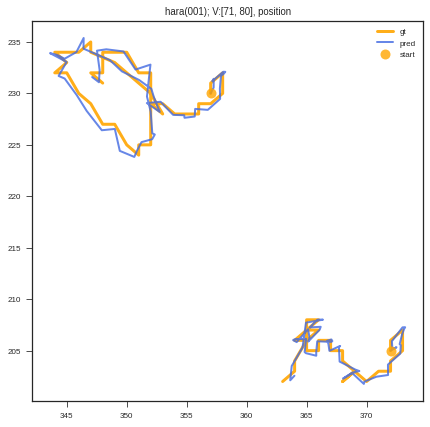

In [52]:
pos = model_results[dataset_k][mov_i]['targets']['pos']
pos_p = model_results[dataset_k][mov_i]['predictions']['pos']

e_st = model_results[dataset_k][mov_i]['edge_index'][:,k]
e_st_list = e_st.ravel().tolist()
plt.figure(figsize=[7,7])
plt.plot(pos[:,e_st_list,0],pos[:,e_st_list,1], '-', c='orange', lw=3, alpha=.9,label=['gt']+[None for k in range(len(e_st_list)-1)])
plt.plot(pos_p[:,e_st_list,0],pos_p[:,e_st_list,1], '-',c='royalblue', lw=2, alpha=.8, label=['pred']+[None for k in range(len(e_st_list)-1)]);

plt.plot(pos[0,e_st_list,0],pos[0,e_st_list,1], 'o', c='orange', ms=10, alpha=.8,label='start')
# for e_k in range(e_st.shape[1]):
#     plt.plot(pos[-1,e_st[:,e_k],0],pos[-1,e_st[:,e_k],1], '-', c='orange', lw=4, alpha=.5)
#     plt.plot(pos_p[-1,e_st[:,e_k],0],pos_p[-1,e_st[:,e_k],1], '-',c='navy', lw=4, alpha=.4);
plt.title(f'{dataset_k}({mov_i}); V:{e_st_list}, position')
# plt.xlim([340, 380])
# plt.ylim([240, 200])
# plt.axis(False)
plt.legend();